# RC Circuit Response Prediction using LSTM
This notebook demonstrates how to:
- Generate synthetic time-series data for an RC circuit.
- Preprocess the data.
- Build and train an LSTM neural network.
- Evaluate and visualize predictions vs actual responses.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [2]:
# Step 1: Generate Synthetic Time-Series Data for RC Circuit
np.random.seed(42)
num_samples = 1000
num_timesteps = 50  # predict 50 time points

# Random R, C, V_in values
R_values = np.random.uniform(100, 1000, num_samples)
C_values = np.random.uniform(1e-6, 1e-3, num_samples)
V_in_values = np.random.uniform(5, 15, num_samples)

# Time vector (0 to 0.05s)
time = np.linspace(0, 0.05, num_timesteps)

# Generate responses
responses = []
for i in range(num_samples):
    R, C, Vin = R_values[i], C_values[i], V_in_values[i]
    V_out = Vin * (1 - np.exp(-time / (R * C)))
    responses.append(V_out)
responses = np.array(responses)

# Features: R, C, Vin repeated for each timestep
X = np.column_stack((R_values, C_values, V_in_values))
X_norm = (X - X.mean(axis=0)) / X.std(axis=0)

# Repeat normalized features across timesteps for LSTM input
X_seq = np.repeat(X_norm[:, np.newaxis, :], num_timesteps, axis=1)

# Target: responses
Y_seq = responses

In [3]:
# Step 2: Build LSTM Model
model = Sequential([
    LSTM(32, input_shape=(num_timesteps, 3), return_sequences=True),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [4]:
# Step 3: Train Model
history = model.fit(X_seq, Y_seq[..., np.newaxis], epochs=50, batch_size=32, verbose=1)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 7.6745
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.3057
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 2.3050
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.4920
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 1.0052
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7158
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.7034
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.4324
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.4732
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.3206
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.4645
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3533
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.3333
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2447
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.2665
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


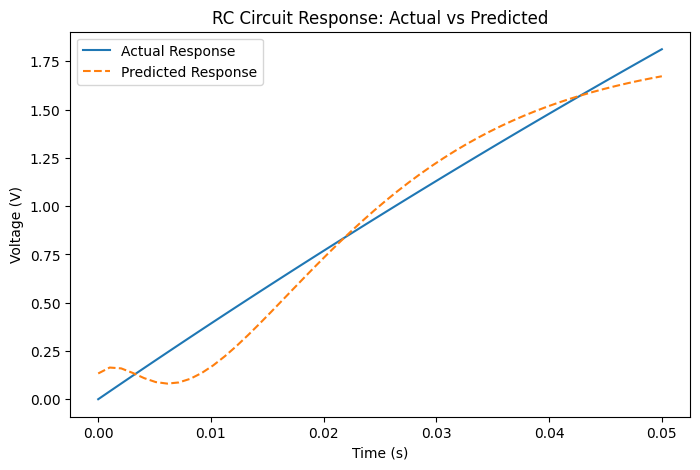

Actual final voltage: 1.8127 V
Predicted final voltage: 1.6727 V


In [5]:
# Step 4: Test Prediction
# Example: R=500Ω, C=500uF, V_in=10V
test_R, test_C, test_Vin = 500, 500e-6, 10
X_test = np.array([[test_R, test_C, test_Vin]])
X_test_norm = (X_test - X.mean(axis=0)) / X.std(axis=0)
X_test_seq = np.repeat(X_test_norm[:, np.newaxis, :], num_timesteps, axis=1)

predicted_response = model.predict(X_test_seq)[0,:,0]
actual_response = test_Vin * (1 - np.exp(-time / (test_R * test_C)))

# Plot Prediction vs Actual
plt.figure(figsize=(8,5))
plt.plot(time, actual_response, label='Actual Response')
plt.plot(time, predicted_response, label='Predicted Response', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.title('RC Circuit Response: Actual vs Predicted')
plt.legend()
plt.show()

print(f"Actual final voltage: {actual_response[-1]:.4f} V")
print(f"Predicted final voltage: {predicted_response[-1]:.4f} V")